### Problem Statement:

It seems that staying in shape has never been more important to the American public. Not only are people becoming more and more concerned about their fitness, but also with an ongoing, once in a century pandemic, getting outdoors has never been more in demand. With the perfect storm of an increased desire to stay in shape while gyms and health clubs across America are closing or being restricted due to the Covid-19 pandemic, cycling has never been more popular. Cycling is the perfect socially distant fitness activity and a great way to exercise while getting some fresh air and a change of scenery from the increase in new home offices. Due to these circumstances, Helmet Heads has seen an increased demand for their product and would like to make more accurate choices when deciding what items to keep in their warehouses. Having products sit in a warehouse for months on end costs the company a lot of money and it is far more effective to purchase more models that will sell faster. The decision shouldn’t be taken lightly. Having the ability to identify what bike models to buy and store in the warehouse will be is extremely important. 

Note - Helmet Heads is a fictitious company and the dataset is also fictitious. More information on the dataset is contained here - https://business-science.github.io/sweep/reference/bike_sales.html

### Proposal:

By using the bike sales data set from Github, I will evaluate the models of possible Helmet Heads bike models project sales volumes and classify if this is a good investment for Helmet Heads. By having the ability to enter in a bike model before purchasing and seeing how many bikes are expected to sell will save franchise owners a large amount of money. This is a supervised learning problem; the dataset contains sales volumes for the from 2011 to 2016 and will be able to tell the franchise owners how much of a product will be sold in the future. 

My next steps will include identifying what models to use and what metrics I will use to evaluate them. 

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import plotly.express as px
from scipy import stats
import matplotlib

In [3]:
# link to data
# bikes_url = 'https://github.com/business-science/sweep/blob/master/data/bike_sales.rda?raw=true'
# I opened the file in R and saved it as a csv file

# load the data
bike_data = pd.read_csv('bike_sale.csv', index_col = 0)
# create seperate columns for the year, month and day of week
bike_data['year'] = pd.DatetimeIndex(bike_data['order.date']).year
bike_data['month'] = pd.DatetimeIndex(bike_data['order.date']).month
bike_data['weekday_name'] = pd.DatetimeIndex(bike_data['order.date']).dayofweek #Monday=0, Sunday=6.

# add in a new column for region as a nother variable
regions_df = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
regions_df = regions_df.rename(columns = {'State Code':'bikeshop.state'})
bike_data = bike_data.merge(regions_df, on='bikeshop.state', how='left')
bike_data = bike_data.drop(['State'], axis=1)

# look at the first five rows
bike_data.head()

,order.date,order.id,order.line,quantity,price,price.ext,customer.id,bikeshop.name,bikeshop.city,bikeshop.state,...,product.id,model,category.primary,category.secondary,frame,year,month,weekday_name,Region,Division
0,2011-01-07,1,1,1,6070,6070.0,2,Ithaca Mountain Climbers,Ithaca,NY,...,48,Jekyll Carbon 2,Mountain,Over Mountain,Carbon,2011,1,4,Northeast,Middle Atlantic
1,2011-01-07,1,2,1,5970,5970.0,2,Ithaca Mountain Climbers,Ithaca,NY,...,52,Trigger Carbon 2,Mountain,Over Mountain,Carbon,2011,1,4,Northeast,Middle Atlantic
2,2011-01-10,2,1,1,2770,2770.0,10,Kansas City 29ers,Kansas City,KS,...,76,Beast of the East 1,Mountain,Trail,Aluminum,2011,1,0,Midwest,West North Central
3,2011-01-10,2,2,1,5970,5970.0,10,Kansas City 29ers,Kansas City,KS,...,52,Trigger Carbon 2,Mountain,Over Mountain,Carbon,2011,1,0,Midwest,West North Central
4,2011-01-10,3,1,1,10660,10660.0,6,Louisville Race Equipment,Louisville,KY,...,2,Supersix Evo Hi-Mod Team,Road,Elite Road,Carbon,2011,1,0,South,East South Central


In [4]:
# review the dimensions of the dataframe
print("Thetable has {} columns and {} rows".format(len(bike_data.columns),len(bike_data)))

Thetable has 22 columns and 15644 rows


In [5]:
# idenitfy if any of the rows have na values
bike_data.isna().sum()

order.date            0
order.id              0
order.line            0
quantity              0
price                 0
price.ext             0
customer.id           0
bikeshop.name         0
bikeshop.city         0
bikeshop.state        0
latitude              0
longitude             0
product.id            0
model                 0
category.primary      0
category.secondary    0
frame                 0
year                  0
month                 0
weekday_name          0
Region                0
Division              0
dtype: int64

No NA values makes life much easier

In [6]:
# review the data types for each of the variables
print("\nData Types:\n")
print(bike_data.dtypes)


Data Types:

order.date             object
order.id                int64
order.line              int64
quantity                int64
price                   int64
price.ext             float64
customer.id             int64
bikeshop.name          object
bikeshop.city          object
bikeshop.state         object
latitude              float64
longitude             float64
product.id              int64
model                  object
category.primary       object
category.secondary     object
frame                  object
year                    int64
month                   int64
weekday_name            int64
Region                 object
Division               object
dtype: object


In [36]:
# review the metrics for each of the numerica variables
bike_data.describe()

,order.id,order.line,quantity,price,price.ext,customer.id,latitude,longitude,product.id,year,month,weekday_name
count,15644.000000,15644.000000,15644.000000,15644.000000,1.564400e+04,15644.000000,15644.000000,15644.000000,15644.000000,15644.000000,15644.000000,15644.000000
mean,997.953081,8.471619,8.567374,3521.110969,3.016988e+04,13.458195,37.942601,-95.049026,49.475326,2013.196561,6.120366,1.994055
std,569.694443,6.816723,52.363404,2667.194590,2.290462e+05,7.716678,4.591913,13.423425,28.231556,1.388683,3.051837,1.331910
min,1.000000,1.000000,1.000000,415.000000,4.150000e+02,1.000000,25.761680,-122.676482,1.000000,2011.000000,1.000000,0.000000
25%,520.000000,3.000000,1.000000,1840.000000,1.950000e+03,8.000000,35.467560,-104.990251,25.000000,2012.000000,4.000000,1.000000
50%,985.500000,7.000000,1.000000,2700.000000,3.200000e+03,10.000000,39.114053,-94.627464,48.000000,2013.000000,6.000000,2.000000
75%,1490.000000,13.000000,1.000000,4260.000000,7.000000e+03,19.000000,40.440625,-83.743038,75.000000,2014.000000,8.000000,3.000000
max,2000.000000,30.000000,1000.000000,12790.000000,1.066000e+07,30.000000,47.606209,-71.412834,97.000000,2015.000000,12.000000,4.000000


Most of the columns look ok - the rea variables to focus in on are quantity, price and price.ext. There looks like there are some outliers for prices/price.ext and quantity. I will look deeper into those to make sure they are accurate. The other variables like year, month, day, order.line all look ok. 

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb7e7485bd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb7e73bced0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb7e7485b90>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb7e73ac950>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb7e73ace50>],
 'means': []}

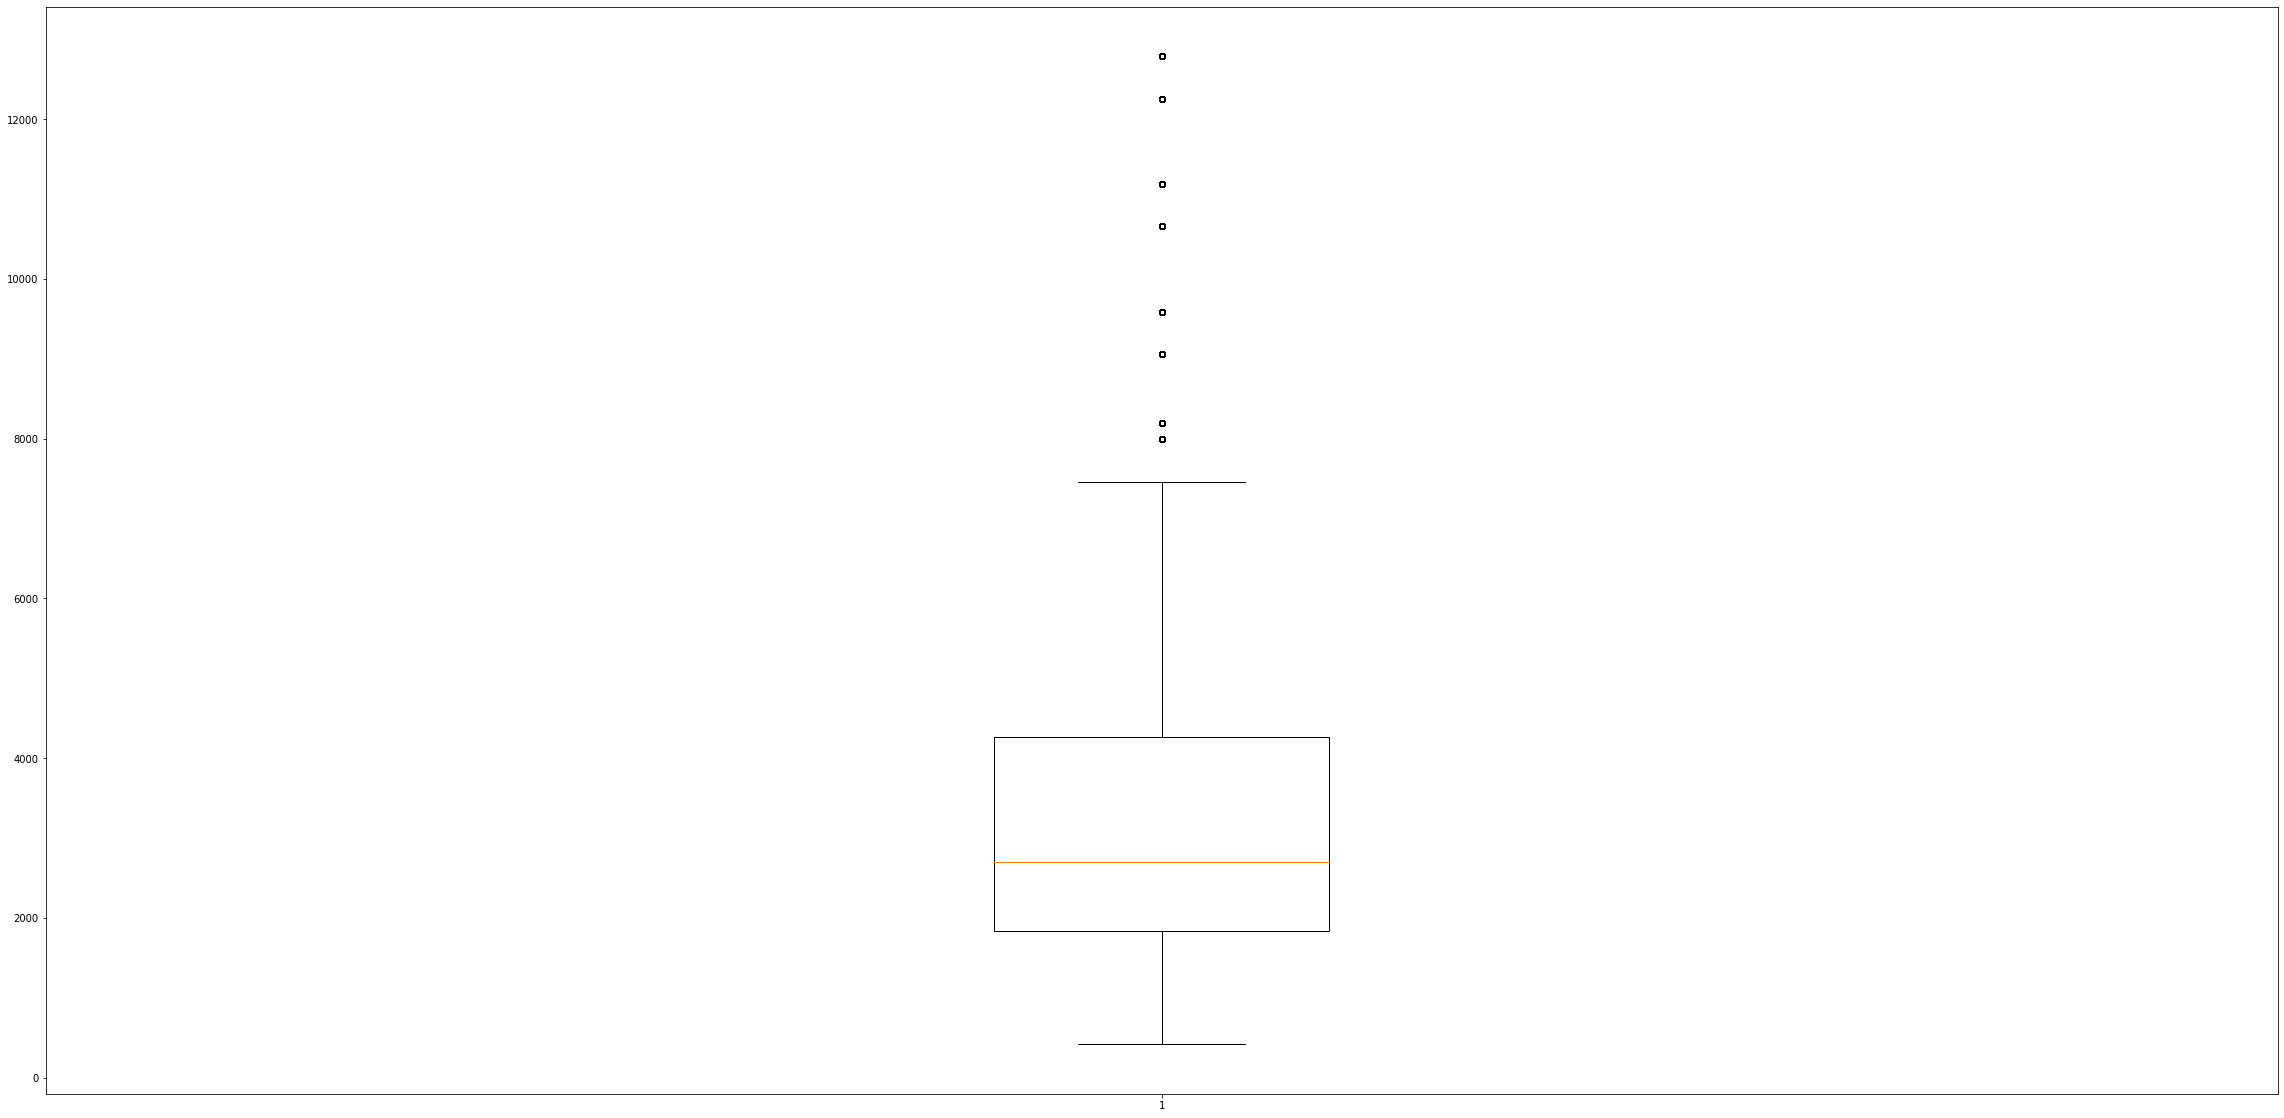

In [37]:
plt.boxplot(bike_data['price'])

The boxplot shows there are some values that could potentially be outliers. I will Create an array containing the z scores for each value in the price column. Z-scores can quantify the unusualness of an observation when your data follow the normal distribution. Z-scores are the number of standard deviations above and below the mean that each value falls.

In [38]:
z_score = stats.zscore(bike_data['price'])
# Create a data frame with a new column z_score to investigate the outliers further
# An outlier is any SPS score that has a z score greater than 3 or less than -3.
df_outlier_test = bike_data
df_outlier_test['z_score'] = z_score
df_outlier_test = df_outlier_test[df_outlier_test['z_score'] < -3]

def plural_outliers(count):
    if count == 1:
        x ='outlier'
    else:
        x = 'outliers'
    return x

outlier_count = df_outlier_test.shape[0]
# The number of rows in the new data frames would be the number of outliers
print("There are",outlier_count,plural_outliers(outlier_count),'in this dataset')

There are 0 outliers in this dataset


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb7e72c6f10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb7e72ea610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb7e72c6ed0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb7e72efbd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb7e72df590>],
 'means': []}

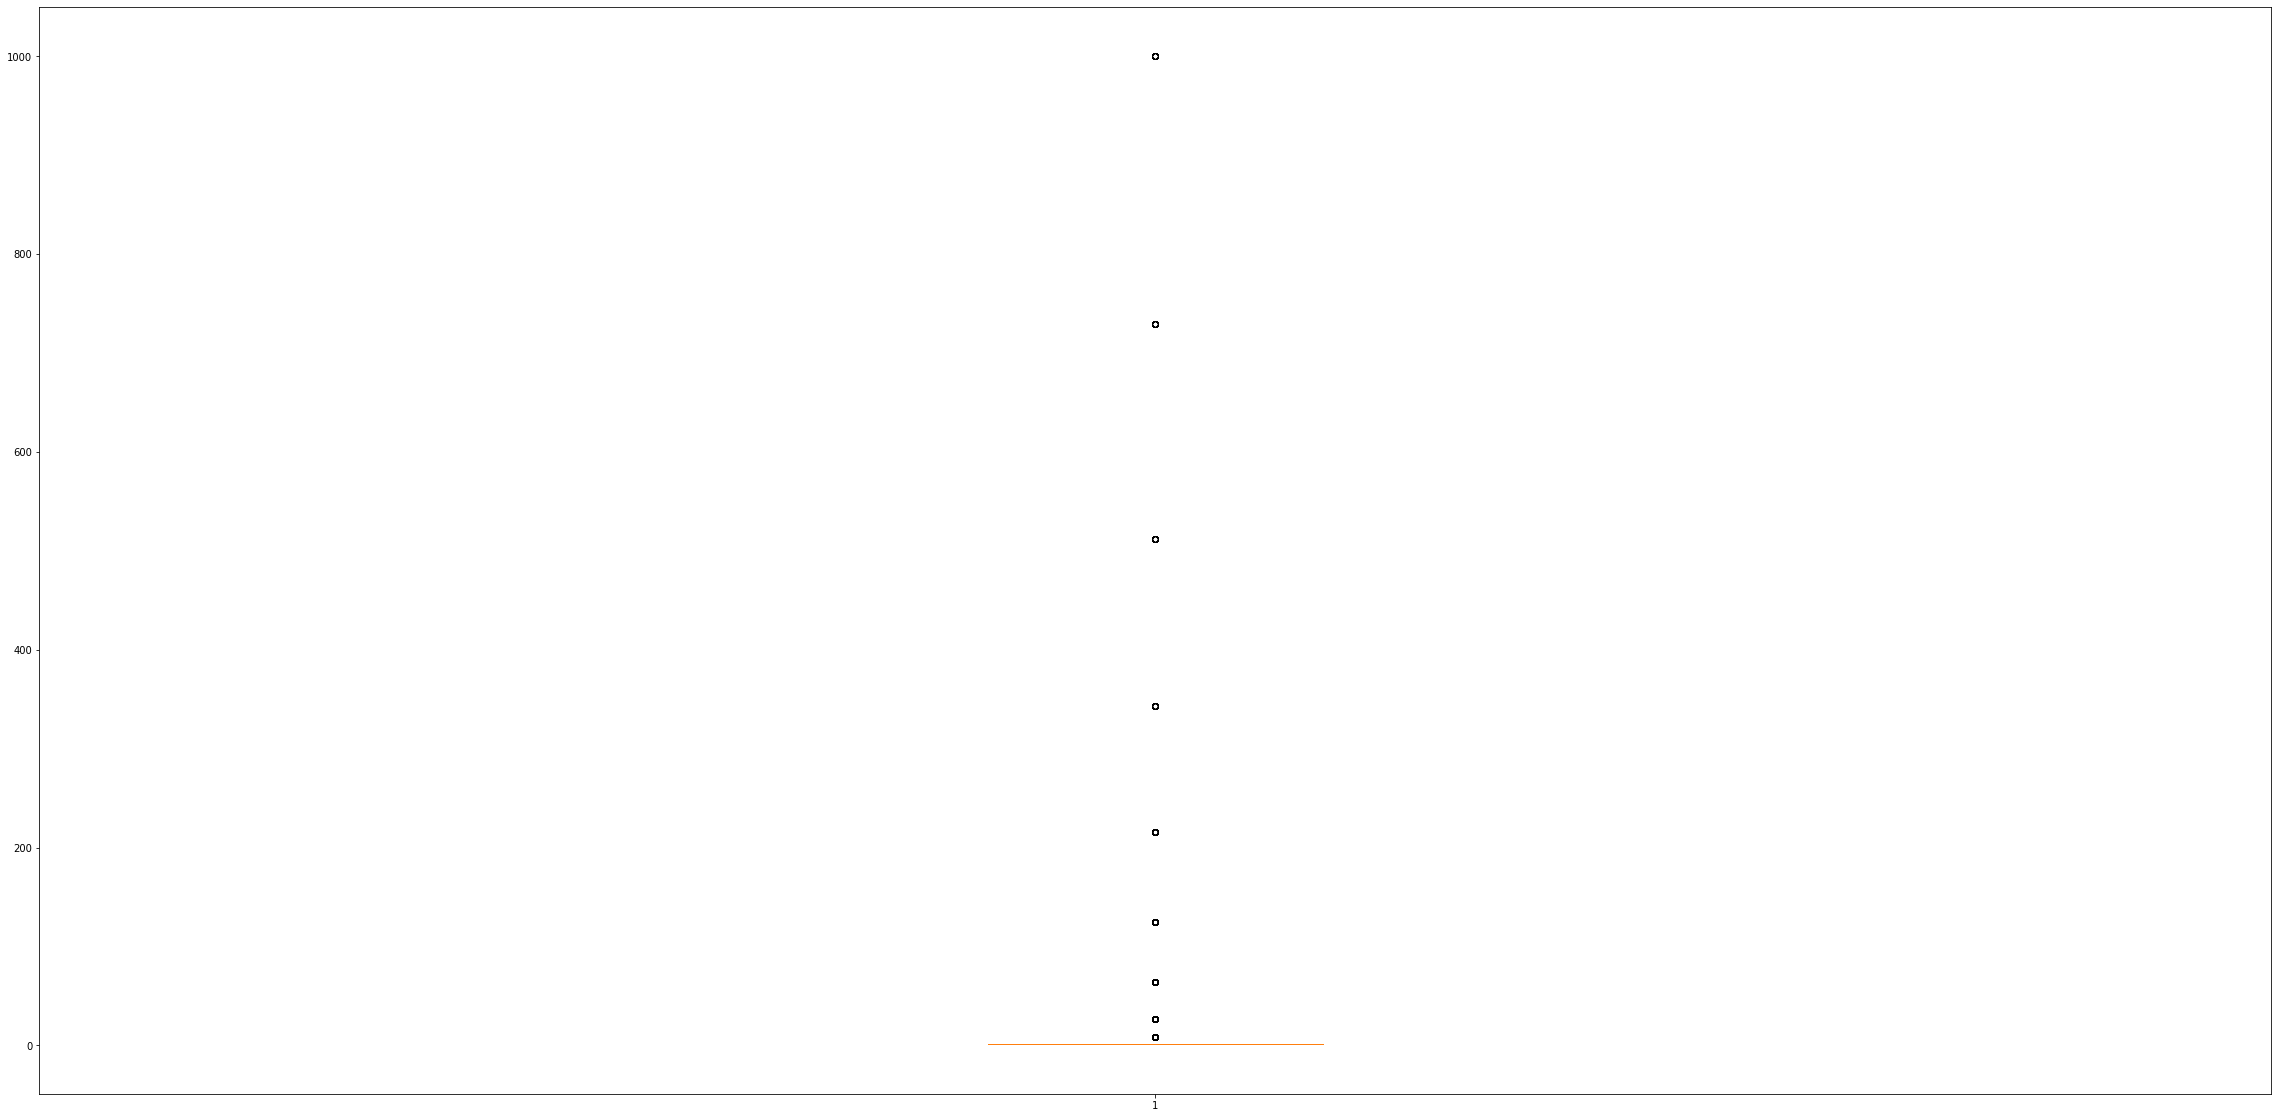

In [39]:
plt.boxplot(bike_data['quantity'])

In [40]:
z_score = stats.zscore(bike_data['quantity'])
# Create a data frame with a new column z_score to investigate the outliers further
# An outlier is any SPS score that has a z score greater than 3 or less than -3.
df_outlier_test = bike_data
df_outlier_test['z_score'] = z_score
df_outlier_test = df_outlier_test[df_outlier_test['z_score'] < -3]

def plural_outliers(count):
    if count == 1:
        x ='outlier'
    else:
        x = 'outliers'
    return x

outlier_count = df_outlier_test.shape[0]
# The number of rows in the new data frames would be the number of outliers
print("There are",outlier_count,plural_outliers(outlier_count),'in this dataset')

There are 0 outliers in this dataset


In [41]:
bike_data = bike_data.drop(['z_score'], axis=1)

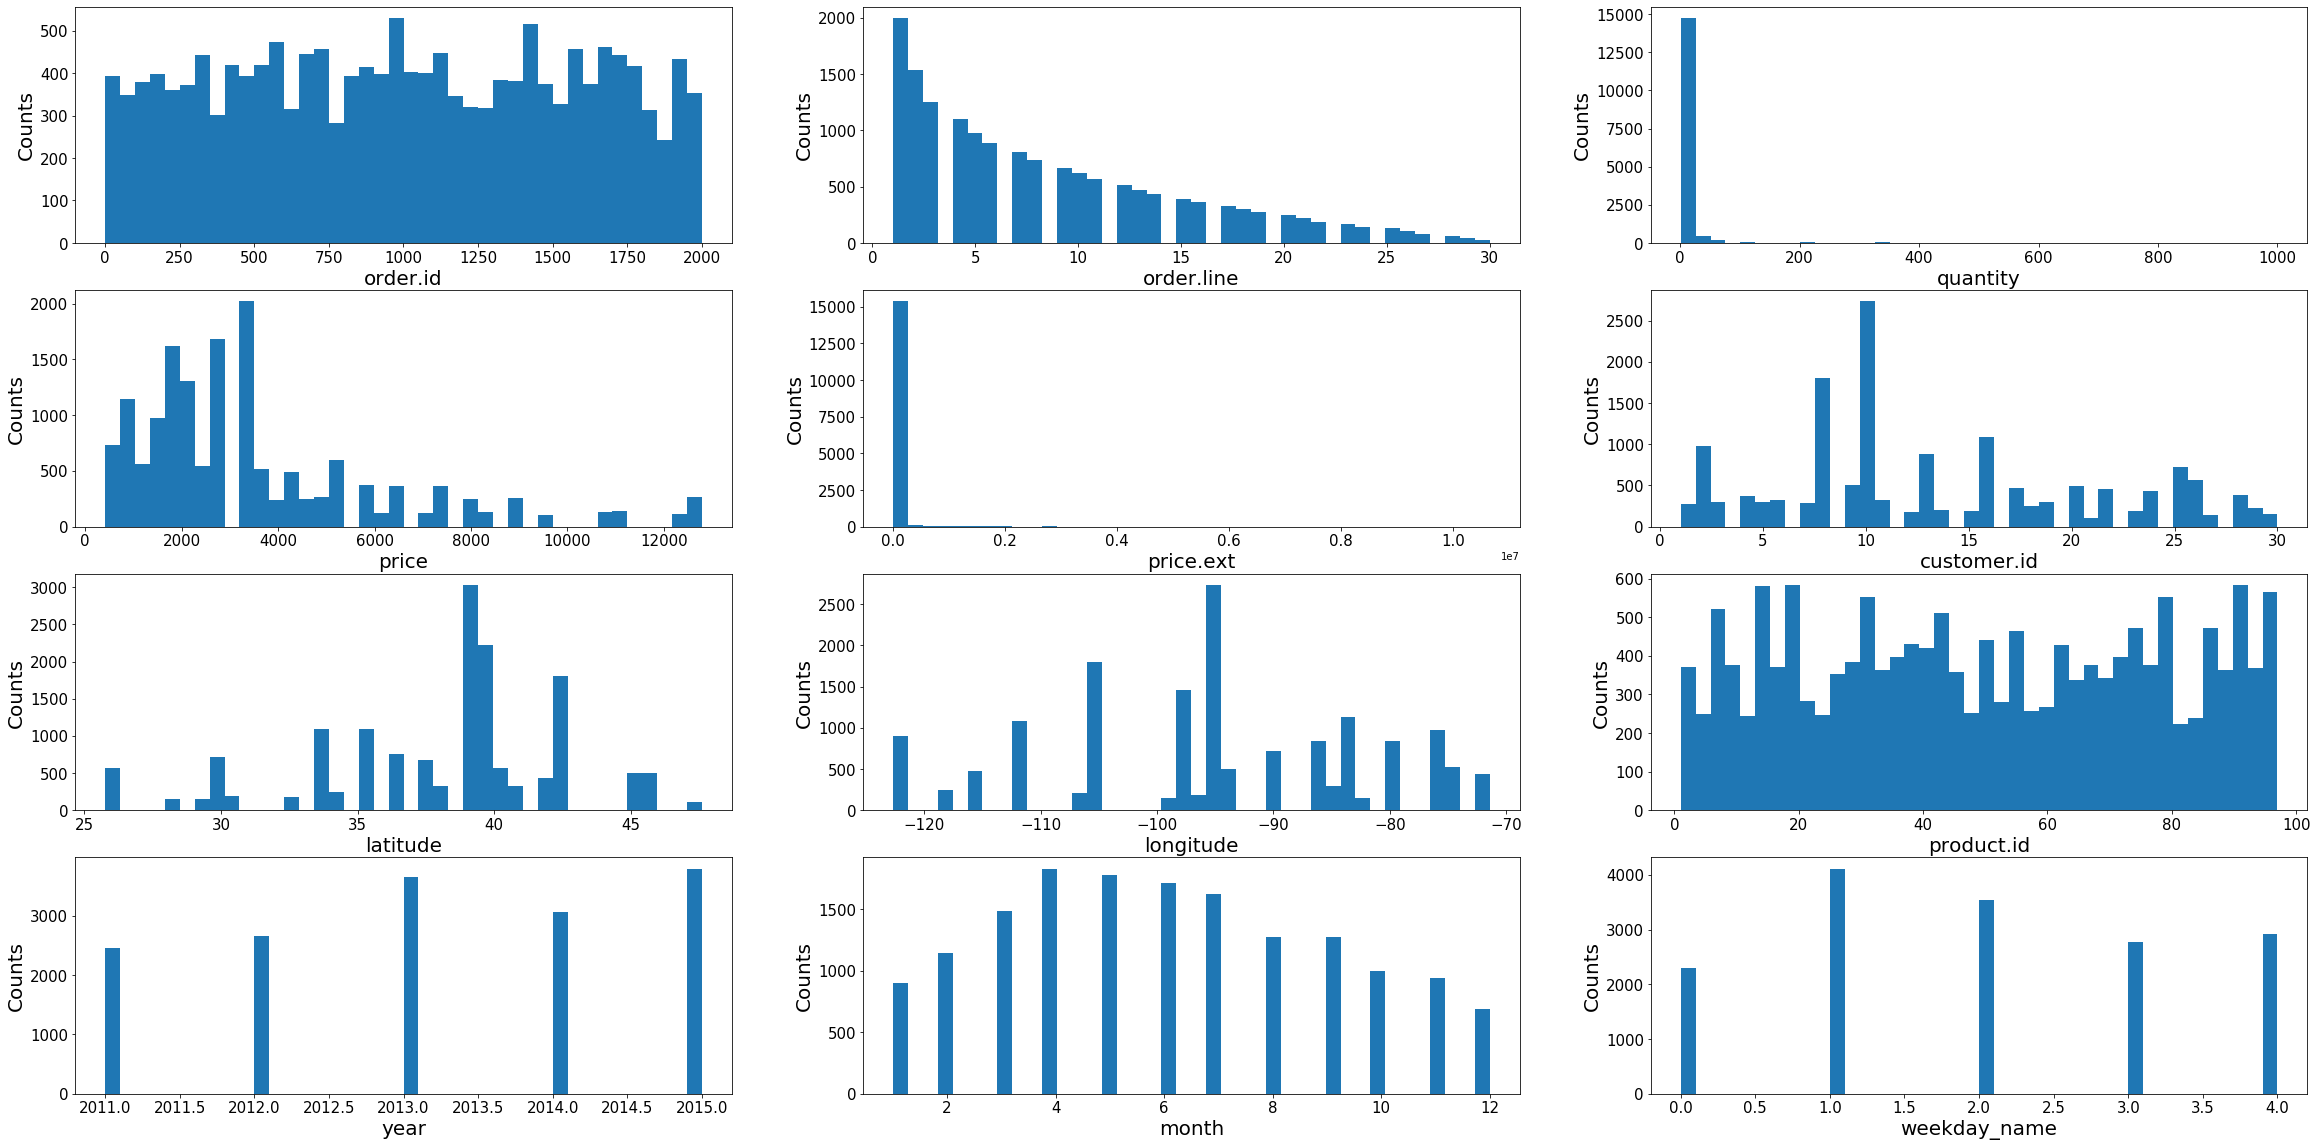

In [42]:
# create histograms for all the numerical values and review their distributions
num_features = []
for col in bike_data:
    if bike_data[col].dtypes != "object":
        num_features.append(col)

plt.rcParams['figure.figsize'] = (40, 20)
fig, axes = plt.subplots(nrows = int((len(num_features)/3)), ncols = 3)

xaxes = num_features
yaxes = ['Counts']*len(num_features)

# draw histograms
axes = axes.ravel()
# the for statements goes through the 4 features identified and creates histograms of them
for idx, ax in enumerate(axes):
    ax.hist(bike_data[num_features[idx]].dropna(), bins=40)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=15)
plt.show()

Some immediate observations from the variables:
- order.line and quantity are skewed right with more customers ordering a small amount per order
- price is skwewed right as well with more customers staying around 4k and less
- product.id is fairly evenly distributed with no product being the overwhelming best seller
- It looks like there has been a steady increase in volume except for a sip in 2014
- Spring and the begining of the week seems to be the best selling timeframe

In [43]:
# Review the unique values in each categorical variable
def categorical_unique(data):
    for col in data:
        if data[col].dtypes == "object":
            print("Column Name Is: " + str(col)+" and it contains "+str(len(data[col].unique())) + " Unique Values")
            if len(data[col].unique()) < 10:
                print("The Unique Values Are: " + str(data[col].unique())+str("\n"))
            else:
                print("There Are Too Many Values To List\n")
        else:
            pass

categorical_unique(bike_data)

Column Name Is: order.date and it contains 962 Unique Values
There Are Too Many Values To List

Column Name Is: bikeshop.name and it contains 30 Unique Values
There Are Too Many Values To List

Column Name Is: bikeshop.city and it contains 30 Unique Values
There Are Too Many Values To List

Column Name Is: bikeshop.state and it contains 21 Unique Values
There Are Too Many Values To List

Column Name Is: model and it contains 97 Unique Values
There Are Too Many Values To List

Column Name Is: category.primary and it contains 2 Unique Values
The Unique Values Are: ['Mountain' 'Road']

Column Name Is: category.secondary and it contains 9 Unique Values
The Unique Values Are: ['Over Mountain' 'Trail' 'Elite Road' 'Endurance Road' 'Sport'
 'Cross Country Race' 'Cyclocross' 'Triathalon' 'Fat Bike']

Column Name Is: frame and it contains 2 Unique Values
The Unique Values Are: ['Carbon' 'Aluminum']

Column Name Is: Region and it contains 4 Unique Values
The Unique Values Are: ['Northeast' 'Midw

The variables that would be good to slice and dice on based on their lower amount of unqiue values include category.primary, category.secondary, frame, Region and Division

In [44]:
# creat a function that returns a list of correlations greater than 0.20
def corr_list(data):
    corr_list = data.corr().unstack().sort_values(kind="quicksort").drop_duplicates()
    corr_df = pd.DataFrame(corr_list).reset_index()
    corr_df.columns = ['Variable_1','Variable_2','Correlation']
    corr_df['Direction'] = np.where(corr_df['Correlation'] > 0, 'Positive', 'Negative')
    corr_df['Correlation'] = corr_df['Correlation'].abs()
    corr_df = corr_df.sort_values(by = 'Correlation', ascending = False)
    corr_df = corr_df[corr_df['Correlation'] != 1]
    return corr_df[corr_df['Correlation']>0.20]

In [45]:
corr_list(bike_data)

,Variable_1,Variable_2,Correlation,Direction
65,order.id,year,0.976273,Positive
64,quantity,price.ext,0.801970,Positive
0,customer.id,latitude,0.481647,Negative


Not a whole lot of useful correlation from the correlation matrix. The only one that is useful is the quantity and price.ext correlation of 0.80. This makes sense it would have a high, positive correlation becuase the more of a product you buy, the higher your price will be. 

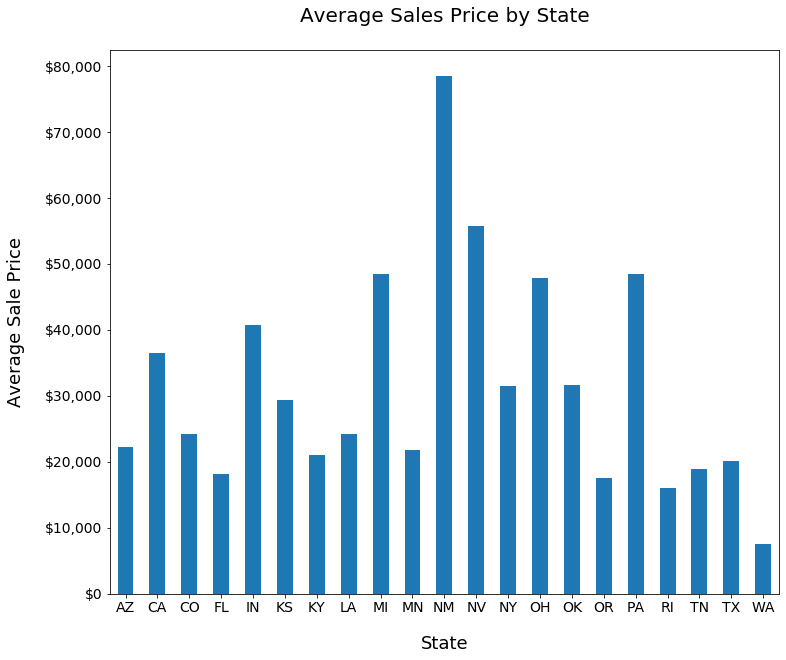

In [69]:
# display bar chart of average sale price sorted by state
ax = bike_data.groupby(['bikeshop.state'])['price.ext'].mean().plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('Average Sales Price by State\n', fontsize=20)
ax.set_xlabel('State', fontsize=18)
ax.set_ylabel('Average Sale Price', fontsize=18)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
ax.yaxis.labelpad = 20
plt.xticks(rotation=0)
ax.xaxis.labelpad = 20
plt.show()

In [71]:
bike_data.groupby(['bikeshop.state'])['price.ext'].mean()

bikeshop.state
AZ    22313.098527
CA    36458.726937
CO    24224.841755
FL    18165.639777
IN    40732.316017
KS    29311.294155
KY    21017.239264
LA    24165.846047
MI    48527.511990
MN    21782.837302
NM    78485.265700
NV    55801.776596
NY    31452.747506
OH    47885.707071
OK    31650.283447
OR    17604.282828
PA    48415.543710
RI    16088.248848
TN    18868.859649
TX    20187.649326
WA     7504.120370
Name: price.ext, dtype: float64

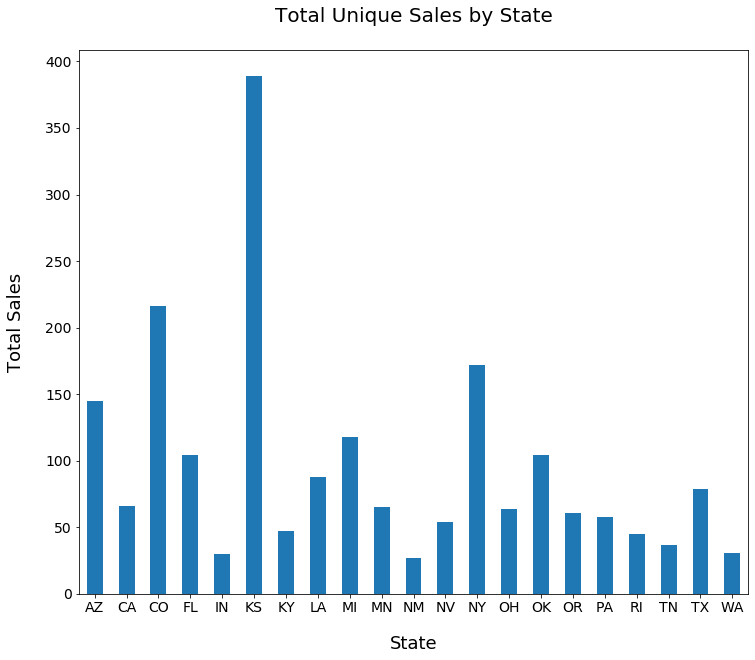

In [62]:
# display bar chart of the total number of unique sales by state
ax = bike_data.groupby(['bikeshop.state'])['order.id'].nunique().plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('Total Unique Sales by State\n', fontsize=20)
ax.set_xlabel('State', fontsize=18)
ax.set_ylabel('Total Sales', fontsize=18)
ax.yaxis.labelpad = 20
plt.xticks(rotation=0)
ax.xaxis.labelpad = 20
plt.show()

In [70]:
# review the average sale price by state, as well as total orders and total shops 
state_df = pd.concat([bike_data.groupby(['bikeshop.state'])['price.ext'].mean(), bike_data.groupby(['bikeshop.state'])['order.id'].nunique()], axis = 1)
state_df.columns = ['Average_Sale','Total_Orders']
state_df['Total_Shops'] = bike_data.groupby(['bikeshop.state'])['bikeshop.name'].nunique()
state_df = state_df.sort_values(by='Average_Sale', ascending = False).reset_index()
state_df

,bikeshop.state,Average_Sale,Total_Orders,Total_Shops
0,NM,78485.265700,27,1
1,NV,55801.776596,54,1
2,MI,48527.511990,118,2
3,PA,48415.543710,58,2
4,OH,47885.707071,64,2
5,IN,40732.316017,30,1
6,CA,36458.726937,66,2
7,OK,31650.283447,104,1
8,NY,31452.747506,172,2
9,KS,29311.294155,389,2


In [81]:
# sort by total orders
state_df = pd.concat([bike_data.groupby(['bikeshop.state'])['price.ext'].mean(), bike_data.groupby(['bikeshop.state'])['order.id'].nunique()], axis = 1)
state_df.columns = ['Average_Sale','Total_Orders']
state_df['Total_Shops'] = bike_data.groupby(['bikeshop.state'])['bikeshop.name'].nunique()
state_df = state_df.sort_values(by='Total_Orders', ascending = False).reset_index()
state_df

,bikeshop.state,Average_Sale,Total_Orders,Total_Shops
0,KS,29311.294155,389,2
1,CO,24224.841755,216,1
2,NY,31452.747506,172,2
3,AZ,22313.098527,145,1
4,MI,48527.511990,118,2
5,FL,18165.639777,104,2
6,OK,31650.283447,104,1
7,LA,24165.846047,88,1
8,TX,20187.649326,79,3
9,CA,36458.726937,66,2


In [86]:
fig = px.choropleth(state_df,  # Input Pandas DataFrame
                    locations="bikeshop.state",  # DataFrame column with locations
                    color="Average_Sale",  # DataFrame column with color values
                    hover_name="bikeshop.state", # DataFrame column hover info
                    locationmode = 'USA-states', color_continuous_scale=["gray", "green"])# Set to plot as US States

fig.update_layout(
    title_text = 'State Rankings', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()  # Output the plot to the screen

In [87]:
# review the percent of mountain bike sales versus road bike sales
road_df = bike_data[bike_data['category.primary'] == 'Road']
mtn_df = bike_data[bike_data['category.primary'] == 'Mountain']
print('The client sells {:.0%} road bikes and {:.0%} mountain bikes'.format((len(road_df)/len(bike_data)),(len(mtn_df)/len(bike_data))))

The client sells 49% road bikes and 51% mountain bikes


In [89]:
# review the metrics on road bikes sold by the company
road_sec_df = pd.DataFrame(road_df.groupby('category.secondary')['order.date'].count())
road_sec_df.columns = ['Total_Sold']
road_sec_df['Average_Price'] = road_df.groupby('category.secondary')['price'].mean().map('${:,.2f}'.format)
road_sec_df['Percent_Sold'] = (road_sec_df['Total_Sold']/len(road_df)).map('{:.0%}'.format)
road_sec_df = road_sec_df.reset_index()
road_sec_df = road_sec_df.rename(columns = {'category.secondary':'Road_2nd_Categ'}).set_index('Road_2nd_Categ')
road_sec_df

,Total_Sold,Average_Price,Percent_Sold
Road_2nd_Categ,,,
Cyclocross,668,"$2,338.71",9%
Elite Road,3472,"$3,433.27",46%
Endurance Road,2586,"$3,080.09",34%
Triathalon,867,"$3,526.59",11%


In [91]:
# review the metrics on mountain bikes sold by the company
mtn_sec_df = pd.DataFrame(mtn_df.groupby('category.secondary')['order.date'].count())
mtn_sec_df.columns = ['Total_Sold']
mtn_sec_df['Average_Price'] = mtn_df.groupby('category.secondary')['price'].mean().map('${:,.2f}'.format)
mtn_sec_df['Percent_Sold'] = (mtn_sec_df['Total_Sold']/len(mtn_df)).map('{:.0%}'.format)
mtn_sec_df = mtn_sec_df.reset_index()
mtn_sec_df = mtn_sec_df.rename(columns = {'category.secondary':'Mountain_2nd_Categ'}).set_index('Mountain_2nd_Categ')
mtn_sec_df

,Total_Sold,Average_Price,Percent_Sold
Mountain_2nd_Categ,,,
Cross Country Race,2852,"$5,266.57",35%
Fat Bike,294,"$2,766.73",4%
Over Mountain,1169,"$5,004.65",15%
Sport,1716,$893.61,21%
Trail,2020,"$3,644.30",25%


In [92]:
# review the metrics on road bikes sold by the company
carbon_df = bike_data[bike_data['frame'] == 'Carbon']
alum_df = bike_data[bike_data['frame'] == 'Aluminum']
print('The client sells {:.0%} carbon framed bikes and {:.0%} aluminum framed bikes'.format((len(carbon_df)/len(bike_data)),(len(alum_df)/len(bike_data))))

The client sells 53% carbon framed bikes and 47% aluminum framed bikes


In [93]:
# review the metrics on the different frames for road bikes sold by the company
road_frame_df = pd.DataFrame(road_df.groupby('frame')['order.date'].count())
road_frame_df.columns = ['Total_Sold']
road_frame_df['Average_Price'] = road_df.groupby('frame')['price'].mean().map('${:,.2f}'.format)
road_frame_df['Percent_Sold'] = (road_frame_df['Total_Sold']/len(road_df)).map('{:.0%}'.format)
road_frame_df = road_frame_df.reset_index()
road_frame_df = road_frame_df.rename(columns = {'frame':'Road_Frame'}).set_index('Road_Frame')
road_frame_df

,Total_Sold,Average_Price,Percent_Sold
Road_Frame,,,
Aluminum,2895,"$1,948.16",38%
Carbon,4698,"$4,015.60",62%


In [94]:
# review the metrics on the different frames for mountain bikes sold by the company
mtn_frame_df = pd.DataFrame(mtn_df.groupby('frame')['order.date'].count())
mtn_frame_df.columns = ['Total_Sold']
mtn_frame_df['Average_Price'] = mtn_df.groupby('frame')['price'].mean().map('${:,.2f}'.format)
mtn_frame_df['Percent_Sold'] = (mtn_frame_df['Total_Sold']/len(mtn_df)).map('{:.0%}'.format)
mtn_frame_df = mtn_frame_df.reset_index()
mtn_frame_df = mtn_frame_df.rename(columns = {'frame':'Mtn_Frame'}).set_index('Mtn_Frame')
mtn_frame_df

,Total_Sold,Average_Price,Percent_Sold
Mtn_Frame,,,
Aluminum,4445,"$1,898.55",55%
Carbon,3606,"$6,139.76",45%


In [97]:
# review the mountain versus road bikes sold by region
region_grpby_df = pd.DataFrame(bike_data.groupby(['Region','category.primary'])['order.date'].count())
region_grpby_df = region_grpby_df.rename(columns = {'order.date':'Total_Sold'})
region_grpby_df

Total_Sold
Region    category.primary            
Midwest   Mountain                2919
          Road                    2358
Northeast Mountain                1408
          Road                     798
South     Mountain                1155
          Road                    2297
West      Mountain                2569
          Road                    2140

In [98]:
# display the percentages and see how they compare to the company as a whole
mw_mtn_per = len(mtn_df[mtn_df['Region'] == 'Midwest']) / (len(mtn_df[mtn_df['Region'] == 'Midwest'])+ len(road_df[road_df['Region'] == 'Midwest']))
mw_road_per = len(road_df[road_df['Region'] == 'Midwest']) / (len(mtn_df[mtn_df['Region'] == 'Midwest'])+ len(road_df[road_df['Region'] == 'Midwest']))

ne_mtn_per = len(mtn_df[mtn_df['Region'] == 'Northeast']) / (len(mtn_df[mtn_df['Region'] == 'Northeast'])+ len(road_df[road_df['Region'] == 'Northeast']))
ne_road_per = len(road_df[road_df['Region'] == 'Northeast']) / (len(mtn_df[mtn_df['Region'] == 'Northeast'])+ len(road_df[road_df['Region'] == 'Northeast']))

so_mtn_per = len(mtn_df[mtn_df['Region'] == 'South']) / (len(mtn_df[mtn_df['Region'] == 'South'])+ len(road_df[road_df['Region'] == 'South']))
so_road_per = len(road_df[road_df['Region'] == 'South']) / (len(mtn_df[mtn_df['Region'] == 'South'])+ len(road_df[road_df['Region'] == 'South']))

we_mtn_per = len(mtn_df[mtn_df['Region'] == 'West']) / (len(mtn_df[mtn_df['Region'] == 'West'])+ len(road_df[road_df['Region'] == 'West']))
we_road_per = len(road_df[road_df['Region'] == 'West']) / (len(mtn_df[mtn_df['Region'] == 'West'])+ len(road_df[road_df['Region'] == 'West']))

print("Midwest: {:.0%} mountain bikes and {:.0%} road bikes".format(mw_mtn_per,mw_road_per))
print("Northeast: {:.0%} mountain bikes and {:.0%} road bikes".format(ne_mtn_per,ne_road_per))
print("South: {:.0%} mountain bikes and {:.0%} road bikes".format(so_mtn_per,so_road_per))
print("West: {:.0%} mountain bikes and {:.0%} road bikes".format(we_mtn_per,we_road_per))

Midwest: 55% mountain bikes and 45% road bikes
Northeast: 64% mountain bikes and 36% road bikes
South: 33% mountain bikes and 67% road bikes
West: 55% mountain bikes and 45% road bikes


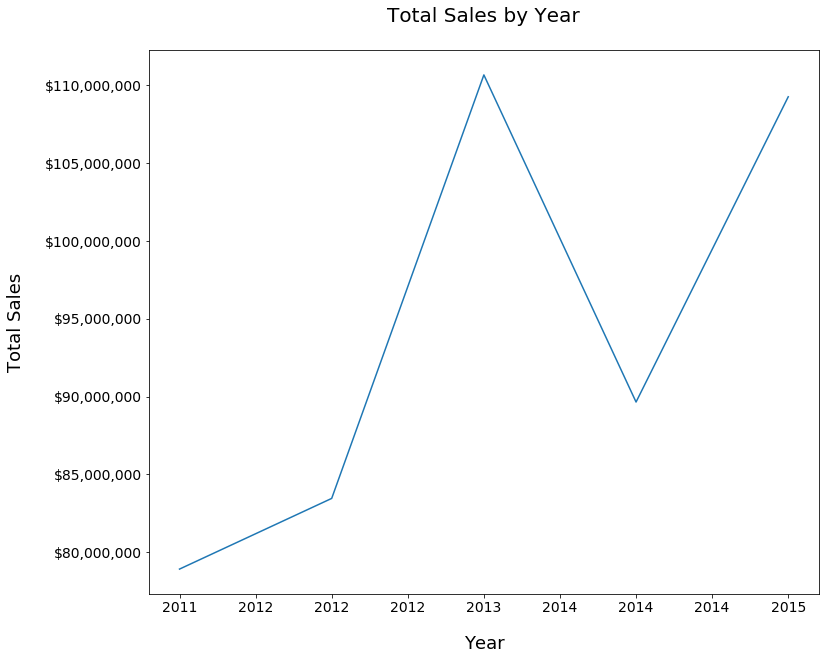

In [129]:
# create a line chart to review the sales by year
ax = bike_data.groupby('year')['price.ext'].sum().plot(kind='line', fontsize=14, figsize=(12,10))
ax.set_title('Total Sales by Year\n', fontsize=20)
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Total Sales', fontsize=18)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
ax.yaxis.labelpad = 20
plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
ax.xaxis.labelpad = 20
plt.show()

In [128]:
# Create a pivot table to show slaes by region by year
pd.pivot_table(bike_data, 'price', 'year', 'Region').reset_index()

Region,year,Midwest,Northeast,South,West
0,2011,3469.733242,4027.384342,3379.611570,3450.047114
1,2012,3536.078732,3914.085052,3338.071571,3485.222646
2,2013,3510.153322,4235.191147,3207.901639,3369.551402
3,2014,3386.204163,4201.064050,3134.717608,3430.220061
4,2015,3543.184116,4249.217626,3373.415961,3439.610516
